In [1]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
from torchvision import datasets, transforms
from torch.utils.data import random_split, TensorDataset, DataLoader
import matplotlib.pyplot as plt
from pathlib import Path
import sys


# climb up to the repo root and add <repo>/src to Python's path
repo_root = Path().resolve().parents[0]   # parent of "notebooks"
sys.path.insert(0, str(repo_root / "src"))

from fisher_information.fim import FisherInformationMatrix
from models.image_classification_models import ConvModelMNIST
from models.train_test import *
#from prunning_methods.LTH import *
from fisher_information.NGD import *

device = "cuda" if torch.cuda.is_available() else "cpu"

In [2]:
mnist_train = torchvision.datasets.MNIST(root='../data', train=True, download=True, transform=torchvision.transforms.ToTensor())
mnist_test = torchvision.datasets.MNIST(root='../data', train=False, download=True, transform=torchvision.transforms.ToTensor())

mnist_train_loader = DataLoader(mnist_train, batch_size = 256, shuffle=True)
mnist_train_fim_loader = DataLoader(mnist_train, batch_size = 1, shuffle=True) 
mnist_test_loader = DataLoader(mnist_test, batch_size = 20, shuffle=True)

In [3]:
fim_args = {"complete_fim": True, 
            "layers":  None, 
            "mask":  None, 
            "sampling_type":  'complete', 
            "sampling_frequency":  None
            }


LTH_args = {"model": ConvModelMNIST().to(device), 
            "criterion": nn.CrossEntropyLoss(), 
            "train_loader": mnist_train_loader, 
            "test_loader": mnist_test_loader, 
            "fim_loader": mnist_train_fim_loader, 
            "fim_args": fim_args, 
            "lr" : 1e-4,
            "n_iterations":10, 
            "n_epochs":30, 
            "prunning_percentage":0.1, 
            "no_prunning_layers":None,
            "real_opt": 'singd', # 'adam' or 'singd'
            "structure": "dense", # "diag" or "dense"
            "verbose":True,
            "print_freq":10, 
            "use_scheduler":False, 
            "save_path":None
            }
           

In [4]:
output_dict = train_LTH_adam_vs_ngd(**LTH_args)


=== LTH Iteration 1/10 ===
Current pruning percentage: 0.000
Epoch [1/30] - train loss: 2.2836 - batches: 235
Epoch [11/30] - train loss: 0.0478 - batches: 235
Epoch [21/30] - train loss: 0.0193 - batches: 235
Epoch [30/30] - train loss: 0.0108 - batches: 235
Test Accuracy after iteration 1: 98.38%

=== LTH Iteration 2/10 ===
Current pruning percentage: 0.100
Epoch [1/30] - train loss: 2.2867 - batches: 235
Epoch [11/30] - train loss: 0.0531 - batches: 235
Epoch [21/30] - train loss: 0.0243 - batches: 235
Epoch [30/30] - train loss: 0.0151 - batches: 235
Test Accuracy after iteration 2: 98.57%

=== LTH Iteration 3/10 ===
Current pruning percentage: 0.200
Epoch [1/30] - train loss: 2.2877 - batches: 235
Epoch [11/30] - train loss: 0.0593 - batches: 235
Epoch [21/30] - train loss: 0.0298 - batches: 235
Epoch [30/30] - train loss: 0.0196 - batches: 235
Test Accuracy after iteration 3: 98.29%

=== LTH Iteration 4/10 ===
Current pruning percentage: 0.300
Epoch [1/30] - train loss: 2.2849 -

In [38]:
output_dict.keys()

dict_keys(['mask_list', 'test_acc', 'fim_list', 'cos_sim_list', 'cos_dist_list'])

100.0% - Acc = 0.98, logdet_ratio = 16333.36, logdet_ratio_per_dim = 3.21
90.0% - Acc = 0.99, logdet_ratio = 14597.31, logdet_ratio_per_dim = 3.19
80.0% - Acc = 0.98, logdet_ratio = 11353.26, logdet_ratio_per_dim = 2.78
70.0% - Acc = 0.98, logdet_ratio = 8795.29, logdet_ratio_per_dim = 2.46
60.0% - Acc = 0.98, logdet_ratio = 6520.68, logdet_ratio_per_dim = 2.13
50.0% - Acc = 0.98, logdet_ratio = 4291.49, logdet_ratio_per_dim = 1.68
40.0% - Acc = 0.98, logdet_ratio = 2666.57, logdet_ratio_per_dim = 1.30
30.0% - Acc = 0.97, logdet_ratio = 1736.25, logdet_ratio_per_dim = 1.12
20.0% - Acc = 0.96, logdet_ratio = 1005.97, logdet_ratio_per_dim = 0.96
10.0% - Acc = 0.86, logdet_ratio = 610.59, logdet_ratio_per_dim = 1.14


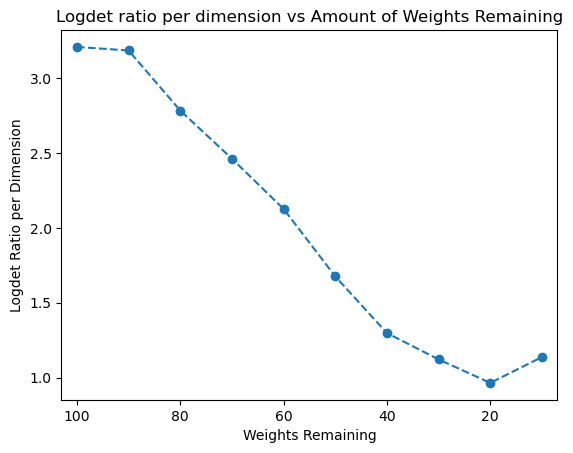

In [87]:
logdet_per_dim_list = []
for idx, fim in enumerate(output_dict["fim_list"]):
    print(f"{100 -(10*idx):.1f}% - Acc = {output_dict['test_acc'][idx]:.2f}, logdet_ratio = {fim.logdet_ratio:.2f}, logdet_ratio_per_dim = {fim.logdet_ratio_per_dim:.2f}")
    logdet_per_dim_list.append(fim.logdet_ratio_per_dim)


plt.title('Logdet ratio per dimension vs Amount of Weights Remaining')
plt.xlabel('Weights Remaining')
plt.ylabel('Logdet Ratio per Dimension')
#plt.xticks((100, 80, 60, 40, 20, 10))
#plt.ylabel('Logdet Ratio per Dimension')
plt.scatter([100 - (10*i) for i in range(len(logdet_per_dim_list))], logdet_per_dim_list)
plt.plot([100 - (10*i) for i in range(len(logdet_per_dim_list))], logdet_per_dim_list, linestyle='--')
plt.xlim(103, 7)
plt.show()

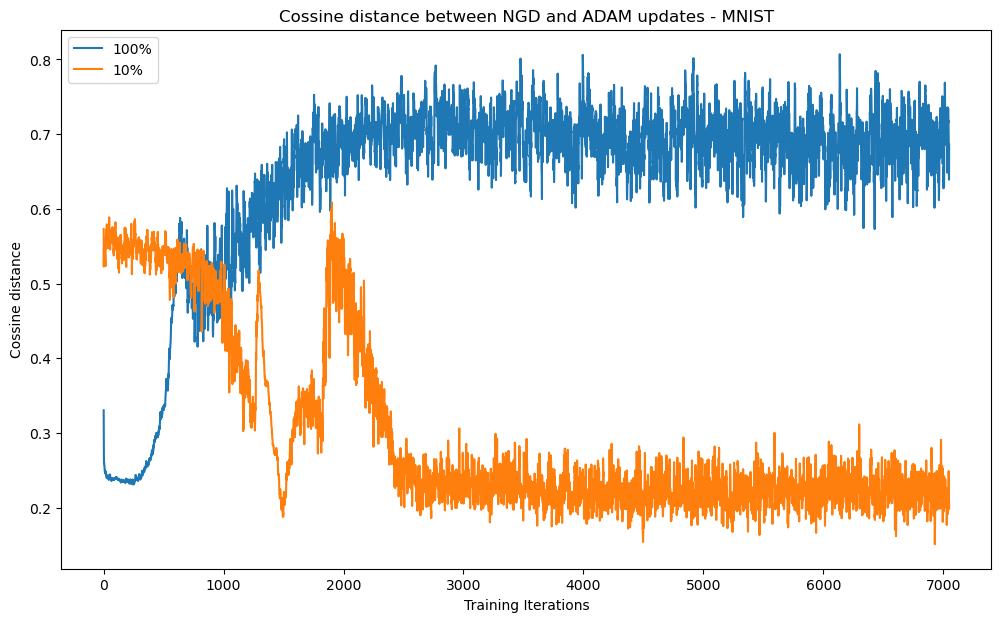

In [59]:
fig, ax = plt.subplots(1,figsize=(12,7))
ax.plot(np.array(output_dict['cos_dist_list'][0]), label='100%')
ax.plot(np.array(output_dict['cos_dist_list'][-1]), label='10%')
plt.title('Cossine distance between NGD and ADAM updates - MNIST')
plt.xlabel('Training Iterations')
plt.ylabel('Cossine distance')
plt.legend()
plt.show()

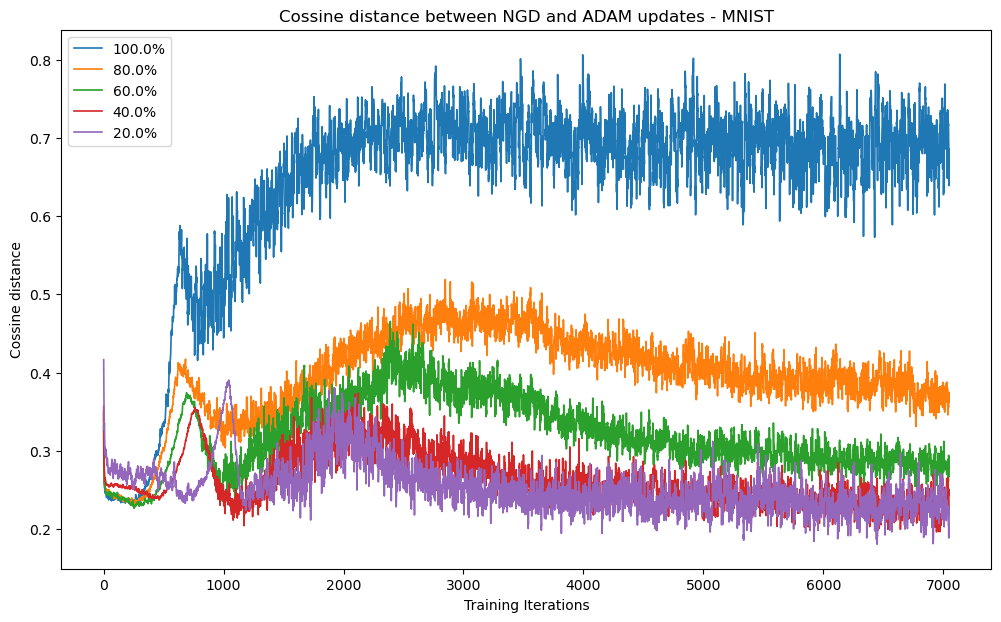

In [60]:
fig, ax = plt.subplots(1,figsize=(12,7))
for i in range(0,len(output_dict['cos_dist_list']),2):
    ax.plot(np.array(output_dict['cos_dist_list'][i]), label=f'{100 -(10*i):.1f}%', linewidth=1.2)

#ax.plot(np.array(output_dict['cos_dist_list'][-1]), label=f'{10:.1f}%', linewidth=1.2)
plt.title('Cossine distance between NGD and ADAM updates - MNIST')
plt.xlabel('Training Iterations')
plt.ylabel('Cossine distance')
plt.legend()
plt.show()

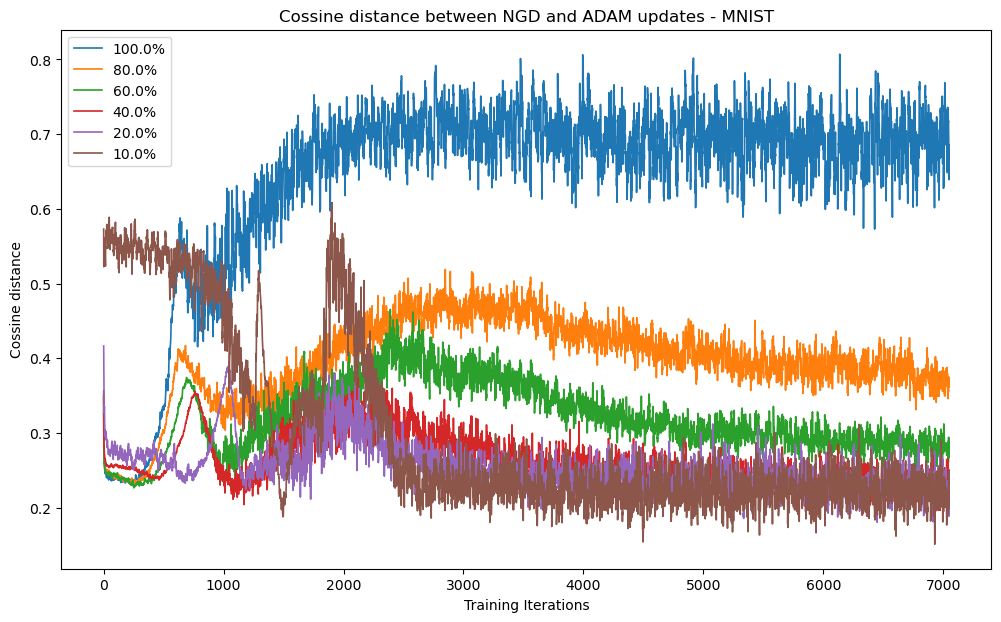

In [63]:
fig, ax = plt.subplots(1,figsize=(12,7))
for i in range(0,len(output_dict['cos_dist_list']),2):
    ax.plot(np.array(output_dict['cos_dist_list'][i]), label=f'{100 -(10*i):.1f}%', linewidth=1.2)

ax.plot(np.array(output_dict['cos_dist_list'][-1]), label=f'{10:.1f}%', linewidth=1.2)
plt.title('Cossine distance between NGD and ADAM updates - MNIST')
plt.xlabel('Training Iterations')
plt.ylabel('Cossine distance')
plt.legend()
plt.show()

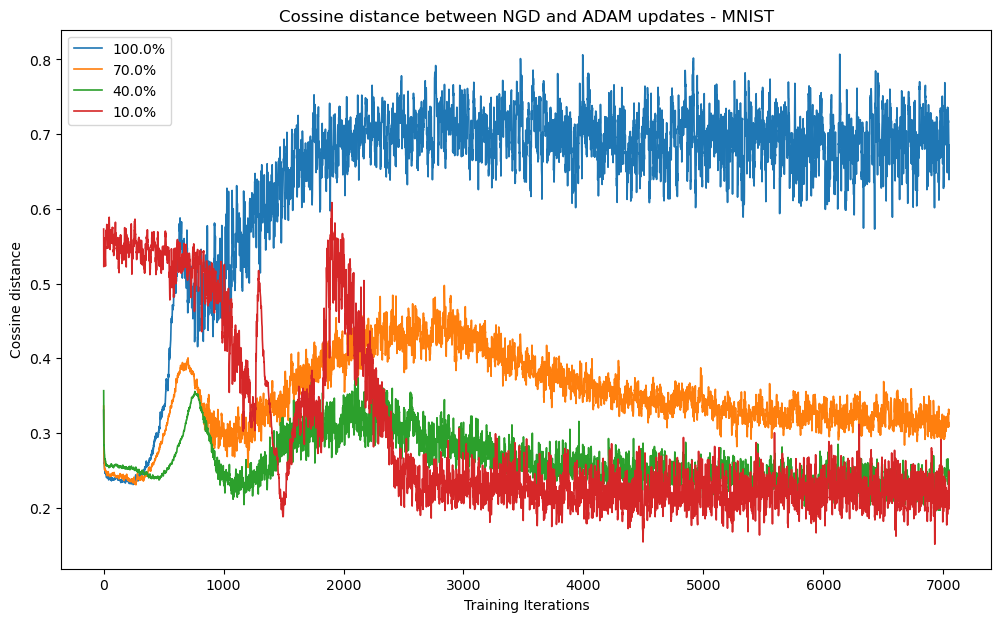

In [64]:
fig, ax = plt.subplots(1,figsize=(12,7))
for i in range(0,len(output_dict['cos_dist_list']),3):
    ax.plot(np.array(output_dict['cos_dist_list'][i]), label=f'{100 -(10*i):.1f}%', linewidth=1.2)

#ax.plot(np.array(output_dict['cos_dist_list'][-1]), label=f'{10:.1f}%', linewidth=1.2)
plt.title('Cossine distance between NGD and ADAM updates - MNIST')
plt.xlabel('Training Iterations')
plt.ylabel('Cossine distance')
plt.legend()
plt.show()

In [ ]:
#torch.save(output_dict, "LTH_NGD_mnist_output_dict_best_result.pth")

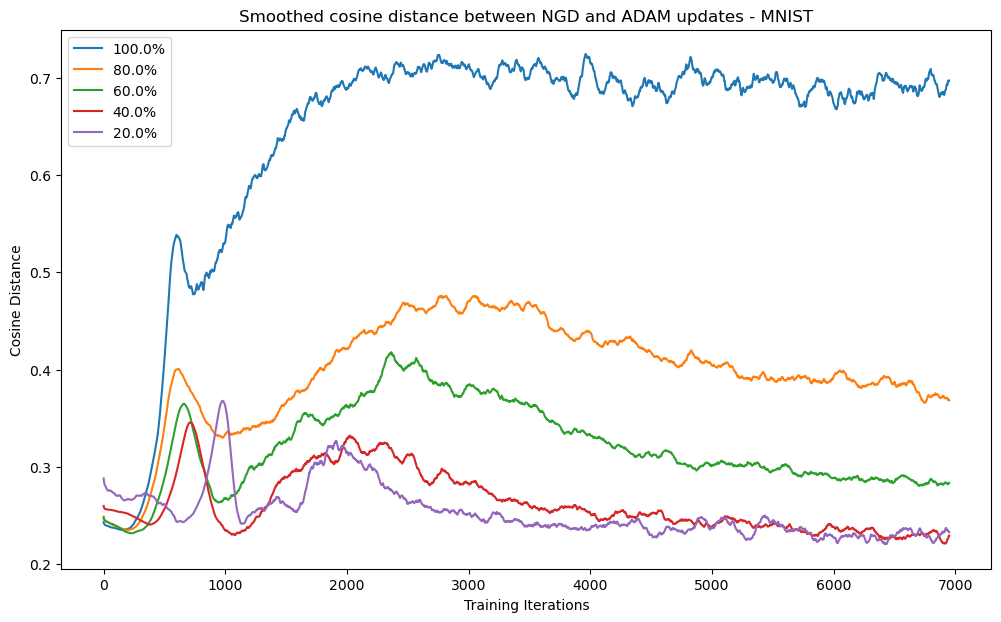

In [71]:
import numpy as np
import matplotlib.pyplot as plt

# define smoothing function
def smooth_curve(x, window_size=50):
    window = np.ones(window_size) / window_size
    return np.convolve(x, window, mode='valid')

fig, ax = plt.subplots(1, figsize=(12, 7))

# loop through and plot smoothed data
for i in range(0, len(output_dict['cos_dist_list']), 2):
    data = np.array(output_dict['cos_dist_list'][i])
    smoothed = smooth_curve(data, window_size=100)  # try 50–200 for different smoothness
    ax.plot(smoothed, label=f'{100 - (10 * i):.1f}%', linewidth=1.5)

    

plt.title('Smoothed cosine distance between NGD and ADAM updates - MNIST')
plt.xlabel('Training Iterations')
plt.ylabel('Cosine Distance')
plt.legend()
plt.savefig('smoothed_cosine_distance_ngd_adam_mnist_1.png')
plt.show()


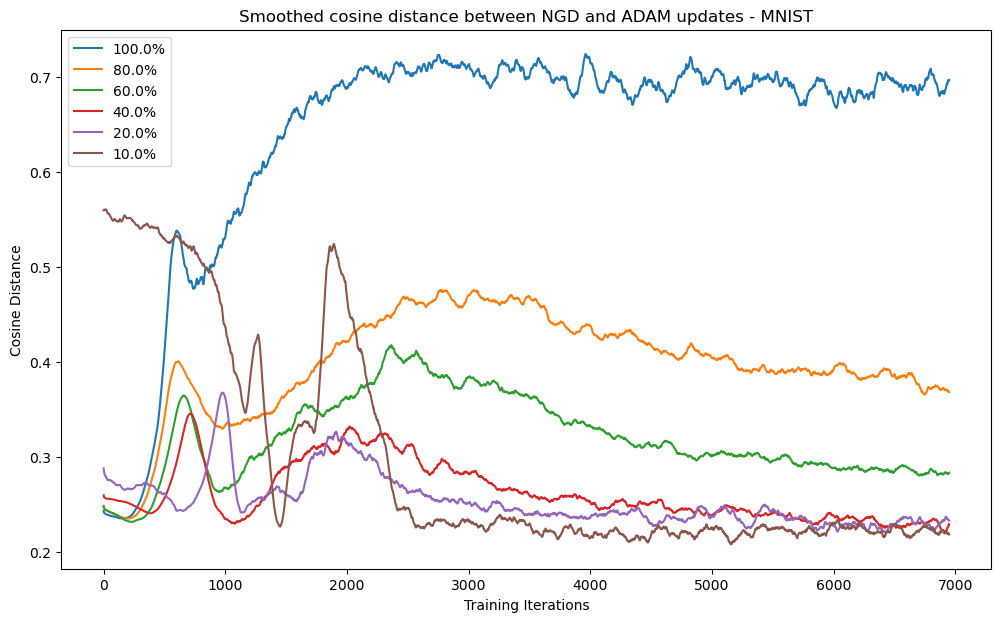

In [70]:
fig, ax = plt.subplots(1, figsize=(12, 7))

# loop through and plot smoothed data
for i in range(0, len(output_dict['cos_dist_list']), 2):
    data = np.array(output_dict['cos_dist_list'][i])
    smoothed = smooth_curve(data, window_size=100)  # try 50–200 for different smoothness
    ax.plot(smoothed, label=f'{100 - (10 * i):.1f}%', linewidth=1.5)


data = np.array(output_dict['cos_dist_list'][-1])
smoothed = smooth_curve(data, window_size=100)  # try 50–200 for different smoothness
ax.plot(smoothed, label=f'{10:.1f}%', linewidth=1.5)

plt.title('Smoothed cosine distance between NGD and ADAM updates - MNIST')
plt.xlabel('Training Iterations')
plt.ylabel('Cosine Distance')
plt.legend()
plt.savefig('smoothed_cosine_distance_ngd_adam_mnist_2.png')
plt.show()
